# Dust Soiling Losses (HSU) — Live, Forecast, and Historic Examples

The following examples shows how to retrieve HSU dust soiling loss using the Solcast Python SDK and visualize the data.

- Live estimated actuals (near real-time and past 7 days)
- Forecast (near real-time and up to 7 days ahead)
- Historic (date-ranged queries; up to 31 days per request)

All requests here use the SDK, returning convenient response objects that can be converted to pandas DataFrames.

## Model Background

The HSU model reports a soiling ratio (equal to 0 − transmission loss) that evolves on sub-hourly time steps. Unlike Kimber’s fixed daily accumulation rate, HSU uses particulate deposition and precipitation accumulation each step to build and clean soiling dynamically. Users can configure rainfall cleaning thresholds, panel tilt, aerosol deposition velocities, particulate matter inputs (PM3.5/PM10), and manual washing schedules. Solcast supplies the precipitation history and, when desired, PM2.5/PM10 concentrations from our meteorological datasets so the model can be run without sourcing external environmental data. The result is a loss series that tracks changing atmospheric conditions and can feed forecasting or yield assessment workflows. See Coello & Boyle, 2019 (IEEE J. Photovoltaics) for the original formulation.

---

## Prerequisites

### Dependencies
- Solcast API key with access to soiling endpoints.
- Python with `solcast`, `pandas`, `matplotlib` installed.
- Set environment variable `SOLCAST_API_KEY`.

In [31]:
# Optional: install packages if needed
# !pip install solcast pandas matplotlib

In [32]:
import os

from solcast import live as solcast_live
from solcast import forecast as solcast_forecast
from solcast import historic as solcast_historic
from solcast.unmetered_locations import UNMETERED_LOCATIONS

### Configurations

In [33]:
API_BASE = os.environ.get("SOLCAST_API_BASE", "https://api.solcast.com.au")

API_KEY = os.environ.get("SOLCAST_API_KEY", "")
if not API_KEY:
    raise ValueError("Missing SOLCAST_API_KEY environment variable.")
HEADERS = {"Authorization": f"Bearer {API_KEY}"}

# Using unmetered location for to avoid API key usage
sydney = UNMETERED_LOCATIONS['Sydney Opera House']

---

## Live Estimated Actuals

Endpoint: /data/live/soiling/hsu

### SDK Parameters

The following SDK function will be used:

In [34]:
help(solcast_live.soiling_hsu)

Help on function soiling_hsu in module solcast.live:

soiling_hsu(latitude: float, longitude: float, **kwargs) -> solcast.api.PandafiableResponse
    Get hourly soiling loss using the HSU model.
    
    Returns a time series of estimated cumulative soiling / cleanliness state for the
    requested location based on Solcast's HSU model.
    
    Args:
        latitude: Decimal degrees, between -90 and 90 (north positive).
        longitude: Decimal degrees, between -180 and 180 (east positive).
        **kwargs: Additional query parameters accepted by the endpoint (e.g. depo_veloc_pm10, initial_soiling).
    
    Returns:
        PandafiableResponse: Response object; call `.to_pandas()` for a DataFrame.
    
    See https://docs.solcast.com.au/ for full parameter details.



### Accessing Additional Parameters

For this example, we will provide additional parameters as specified by the Solcast API docs. Following is a brief summary:

- latitude/longitude (EPSG:4326)
- period: PT5M | PT10M | PT15M | PT20M | PT30M | PT60M (default PT30M)
- tilt: 0..90 (optional; default optimal tilt)
- initial_soiling: 0..0.3437 (fraction at period start)
- manual_wash_dates: list of ISO dates when cleaning occurs
- cleaning_threshold: rainfall (mm) in a rolling 24h window to clean (default 1.0)
- hours: number of past hours to retrieve (max 168)

Tip: Use the SDK’s `.to_pandas()` for quick plotting.


In [35]:
live_params = {
    "latitude": sydney.get("latitude"),
    "longitude": sydney.get("longitude"),
    "manual_wash_dates": "[2022-10-26,2025-11-14,2025-11-26]",
    "period": "PT15M",
    "initial_soiling": 0.1,
    "cleaning_threshold": 1.0,
    "hours": 168,
}
print(live_params)

live_resp = solcast_live.soiling_hsu(base_url=API_BASE, api_key=API_KEY, **live_params)
live_resp

{'latitude': -33.856784, 'longitude': 151.215297, 'manual_wash_dates': '[2022-10-26,2025-11-14,2025-11-26]', 'period': 'PT15M', 'initial_soiling': 0.1, 'cleaning_threshold': 1.0, 'hours': 168}


status code=200, url=https://api.solcast.com.au/data/live/soiling/hsu?latitude=-33.856784&longitude=151.215297&format=json&manual_wash_dates=%5B2022-10-26%2C2025-11-14%2C2025-11-26%5D&period=PT15M&initial_soiling=0.1&cleaning_threshold=1.0&hours=168, method=GET

In [36]:
live_df = live_resp.to_pandas()
live_df.index = live_df.index.tz_convert('australia/sydney') # type: ignore
live_df.head(10)

,hsu_loss_fraction
period_end,
2025-12-01 16:15:00+11:00,0.0006
2025-12-01 16:00:00+11:00,0.0006
2025-12-01 15:45:00+11:00,0.0006
2025-12-01 15:30:00+11:00,0.0006
2025-12-01 15:15:00+11:00,0.0006
2025-12-01 15:00:00+11:00,0.0006
2025-12-01 14:45:00+11:00,0.0006
2025-12-01 14:30:00+11:00,0.0006
2025-12-01 14:15:00+11:00,0.0006


<Axes: xlabel='period_end'>

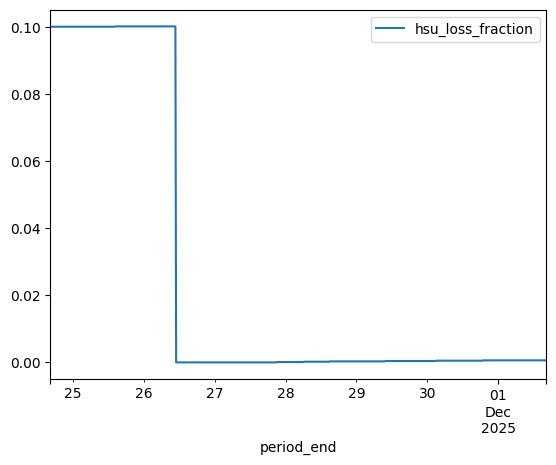

In [37]:
live_df.plot()

---

## Forecast

Endpoint: /data/forecast/soiling/hsu

In [38]:
fc_params = {
    "latitude": sydney.get("latitude"),
    "longitude": sydney.get("longitude"),
    "hours": 72,
    "period": "PT15M",
    "initial_soiling": 0.0,
    "manual_wash_dates": "[2022-10-26,2025-11-14,2025-11-26]",
    "cleaning_threshold": 1.0,
}
print(fc_params)

fc_resp = solcast_forecast.soiling_hsu(base_url=API_BASE, api_key=API_KEY, **fc_params)
fc_resp

{'latitude': -33.856784, 'longitude': 151.215297, 'hours': 72, 'period': 'PT15M', 'initial_soiling': 0.0, 'manual_wash_dates': '[2022-10-26,2025-11-14,2025-11-26]', 'cleaning_threshold': 1.0}


status code=200, url=https://api.solcast.com.au/data/forecast/soiling/hsu?latitude=-33.856784&longitude=151.215297&format=json&hours=72&period=PT15M&initial_soiling=0.0&manual_wash_dates=%5B2022-10-26%2C2025-11-14%2C2025-11-26%5D&cleaning_threshold=1.0, method=GET

In [39]:
fc_df = fc_resp.to_pandas()
fc_df.index = fc_df.index.tz_convert("Australia/Sydney") # type: ignore
fc_df.head(10)

,hsu_loss_fraction
period_end,
2025-12-01 16:30:00+11:00,0.0
2025-12-01 16:45:00+11:00,0.0
2025-12-01 17:00:00+11:00,0.0
2025-12-01 17:15:00+11:00,0.0
2025-12-01 17:30:00+11:00,0.0
2025-12-01 17:45:00+11:00,0.0
2025-12-01 18:00:00+11:00,0.0
2025-12-01 18:15:00+11:00,0.0
2025-12-01 18:30:00+11:00,0.0


<Axes: xlabel='period_end'>

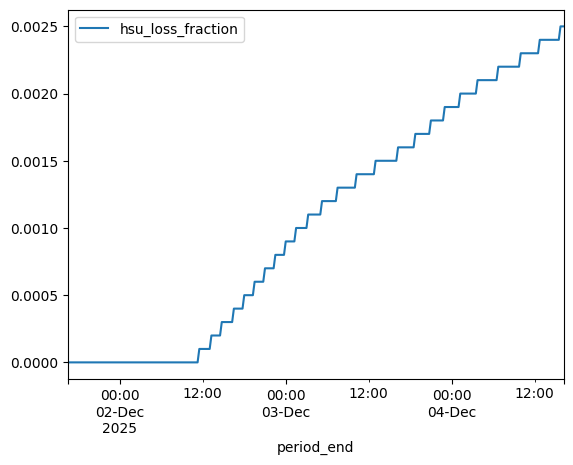

In [40]:
fc_df.plot()

---

## Historic

Endpoint: /data/historic/soiling/hsu

In [41]:
hist_params = {
    "latitude": sydney.get("latitude"),
    "longitude": sydney.get("longitude"),
    "period": "PT15M",
    "start": "2025-10-25T14:45:00Z",
    "duration": "P10D",
    "manual_wash_dates": "[2022-10-26,2025-11-14,2025-11-26]",
}
print(hist_params)

hist_resp = solcast_historic.soiling_hsu(base_url=API_BASE, api_key=API_KEY, **hist_params)
hist_resp

{'latitude': -33.856784, 'longitude': 151.215297, 'period': 'PT15M', 'start': '2025-10-25T14:45:00Z', 'duration': 'P10D', 'manual_wash_dates': '[2022-10-26,2025-11-14,2025-11-26]'}


status code=200, url=https://api.solcast.com.au/data/historic/soiling/hsu?latitude=-33.856784&longitude=151.215297&start=2025-10-25T14%3A45%3A00Z&format=json&period=PT15M&manual_wash_dates=%5B2022-10-26%2C2025-11-14%2C2025-11-26%5D&duration=P10D, method=GET

In [42]:
hist_df = hist_resp.to_pandas()
hist_df.index = hist_df.index.tz_convert('australia/sydney') # type: ignore
hist_df.head(10)

,hsu_loss_fraction
period_end,
2025-10-26 01:45:00+11:00,0.0066
2025-10-26 02:00:00+11:00,0.0066
2025-10-26 02:15:00+11:00,0.0066
2025-10-26 02:30:00+11:00,0.0066
2025-10-26 02:45:00+11:00,0.0066
2025-10-26 03:00:00+11:00,0.0066
2025-10-26 03:15:00+11:00,0.0066
2025-10-26 03:30:00+11:00,0.0066
2025-10-26 03:45:00+11:00,0.0066


<Axes: xlabel='period_end'>

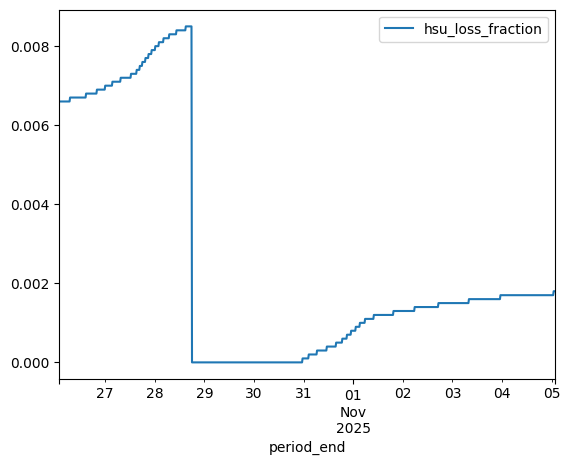

In [43]:
hist_df.plot()

## Troubleshooting
- 401/403: Ensure API key is valid and access includes soiling endpoints.
- Empty payloads: Reduce `hours` or adjust `start`/`duration`.
- Parsing mismatch: Inspect `.to_dict()` from the SDK response and adjust normalization.
- Time zones: Use `.tz_convert()` after setting a UTC index.

Tip: For larger periods, paginate historic queries (max 31 days per request) and concatenate the results in pandas.